### the plan:
1. set up a small sample with 3 classes, 2400 training and 600 testing
2. check we can load/print svgs
3. check keras datagen works with trivial classifier
4. try larger convnet?
    - are larger filters worthwhile?
5. try vgg16 batchnorm insertion trick?

In [1]:
import os
import string
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import keras
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K
import glob
import shutil

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [2]:
# verify if you are using gpu
# this will print to console output
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
tf.__version__

'1.0.1'

### download data

In [4]:
!wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip

--2017-04-12 13:35:28--  http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
Resolving cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)... 130.149.80.52
Connecting to cybertron.cg.tu-berlin.de (cybertron.cg.tu-berlin.de)|130.149.80.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550098987 (525M) [application/zip]
Saving to: ‘sketches_png.zip’

sketches_png.zip    100%[===================>] 524.62M  16.1MB/s    in 53s     

2017-04-12 13:36:21 (9.94 MB/s) - ‘sketches_png.zip’ saved [550098987/550098987]



In [6]:
!unzip sketches_png.zip

Archive:  sketches_png.zip
   creating: png/
   creating: png/airplane/
  inflating: png/airplane/1.png      
  inflating: png/airplane/10.png     
  inflating: png/airplane/11.png     
  inflating: png/airplane/12.png     
  inflating: png/airplane/13.png     
  inflating: png/airplane/14.png     
  inflating: png/airplane/15.png     
  inflating: png/airplane/16.png     
  inflating: png/airplane/17.png     
  inflating: png/airplane/18.png     
  inflating: png/airplane/19.png     
  inflating: png/airplane/2.png      
  inflating: png/airplane/20.png     
  inflating: png/airplane/21.png     
  inflating: png/airplane/22.png     
  inflating: png/airplane/23.png     
  inflating: png/airplane/24.png     
  inflating: png/airplane/25.png     
  inflating: png/airplane/26.png     
  inflating: png/airplane/27.png     
  inflating: png/airplane/28.png     
  inflating: png/airplane/29.png     
  inflating: png/airplane/3.png      
  inflating: png/airplane/30.png     
  inflating: png

  inflating: png/ant/309.png         
  inflating: png/ant/310.png         
  inflating: png/ant/311.png         
  inflating: png/ant/312.png         
  inflating: png/ant/313.png         
  inflating: png/ant/314.png         
  inflating: png/ant/315.png         
  inflating: png/ant/316.png         
  inflating: png/ant/317.png         
  inflating: png/ant/318.png         
  inflating: png/ant/319.png         
  inflating: png/ant/320.png         
   creating: png/apple/
  inflating: png/apple/321.png       
  inflating: png/apple/322.png       
  inflating: png/apple/323.png       
  inflating: png/apple/324.png       
  inflating: png/apple/325.png       
  inflating: png/apple/326.png       
  inflating: png/apple/327.png       
  inflating: png/apple/328.png       
  inflating: png/apple/329.png       
  inflating: png/apple/330.png       
  inflating: png/apple/331.png       
  inflating: png/apple/332.png       
  inflating: png/apple/333.png       
  inflating: png/apple/334

  inflating: png/axe/684.png         
  inflating: png/axe/685.png         
  inflating: png/axe/686.png         
  inflating: png/axe/687.png         
  inflating: png/axe/688.png         
  inflating: png/axe/689.png         
  inflating: png/axe/690.png         
  inflating: png/axe/691.png         
  inflating: png/axe/692.png         
  inflating: png/axe/693.png         
  inflating: png/axe/694.png         
  inflating: png/axe/695.png         
  inflating: png/axe/696.png         
  inflating: png/axe/697.png         
  inflating: png/axe/698.png         
  inflating: png/axe/699.png         
  inflating: png/axe/700.png         
  inflating: png/axe/701.png         
  inflating: png/axe/702.png         
  inflating: png/axe/703.png         
  inflating: png/axe/704.png         
  inflating: png/axe/705.png         
  inflating: png/axe/706.png         
  inflating: png/axe/707.png         
  inflating: png/axe/708.png         
  inflating: png/axe/709.png         
  inflating:

  inflating: png/baseball bat/988.png  
  inflating: png/baseball bat/989.png  
  inflating: png/baseball bat/990.png  
  inflating: png/baseball bat/991.png  
  inflating: png/baseball bat/992.png  
  inflating: png/baseball bat/993.png  
  inflating: png/baseball bat/994.png  
  inflating: png/baseball bat/995.png  
  inflating: png/baseball bat/996.png  
  inflating: png/baseball bat/997.png  
  inflating: png/baseball bat/998.png  
  inflating: png/baseball bat/999.png  
   creating: png/basket/
  inflating: png/basket/1041.png     
  inflating: png/basket/1042.png     
  inflating: png/basket/1043.png     
  inflating: png/basket/1044.png     
  inflating: png/basket/1045.png     
  inflating: png/basket/1046.png     
  inflating: png/basket/1047.png     
  inflating: png/basket/1048.png     
  inflating: png/basket/1049.png     
  inflating: png/basket/1050.png     
  inflating: png/basket/1051.png     
  inflating: png/basket/1052.png     
  inflating: png/basket/1053.png     
 

  inflating: png/bee/1372.png        
  inflating: png/bee/1373.png        
  inflating: png/bee/1374.png        
  inflating: png/bee/1375.png        
  inflating: png/bee/1376.png        
  inflating: png/bee/1377.png        
  inflating: png/bee/1378.png        
  inflating: png/bee/1379.png        
  inflating: png/bee/1380.png        
  inflating: png/bee/1381.png        
  inflating: png/bee/1382.png        
  inflating: png/bee/1383.png        
  inflating: png/bee/1384.png        
  inflating: png/bee/1385.png        
  inflating: png/bee/1386.png        
  inflating: png/bee/1387.png        
  inflating: png/bee/1388.png        
  inflating: png/bee/1389.png        
  inflating: png/bee/1390.png        
  inflating: png/bee/1391.png        
  inflating: png/bee/1392.png        
  inflating: png/bee/1393.png        
  inflating: png/bee/1394.png        
  inflating: png/bee/1395.png        
  inflating: png/bee/1396.png        
  inflating: png/bee/1397.png        
  inflating:

  inflating: png/bicycle/1700.png    
  inflating: png/bicycle/1701.png    
  inflating: png/bicycle/1702.png    
  inflating: png/bicycle/1703.png    
  inflating: png/bicycle/1704.png    
  inflating: png/bicycle/1705.png    
  inflating: png/bicycle/1706.png    
  inflating: png/bicycle/1707.png    
  inflating: png/bicycle/1708.png    
  inflating: png/bicycle/1709.png    
  inflating: png/bicycle/1710.png    
  inflating: png/bicycle/1711.png    
  inflating: png/bicycle/1712.png    
  inflating: png/bicycle/1713.png    
  inflating: png/bicycle/1714.png    
  inflating: png/bicycle/1715.png    
  inflating: png/bicycle/1716.png    
  inflating: png/bicycle/1717.png    
  inflating: png/bicycle/1718.png    
  inflating: png/bicycle/1719.png    
  inflating: png/bicycle/1720.png    
  inflating: png/bicycle/1721.png    
  inflating: png/bicycle/1722.png    
  inflating: png/bicycle/1723.png    
  inflating: png/bicycle/1724.png    
  inflating: png/bicycle/1725.png    
  inflating:

  inflating: png/bookshelf/2021.png  
  inflating: png/bookshelf/2022.png  
  inflating: png/bookshelf/2023.png  
  inflating: png/bookshelf/2024.png  
  inflating: png/bookshelf/2025.png  
  inflating: png/bookshelf/2026.png  
  inflating: png/bookshelf/2027.png  
  inflating: png/bookshelf/2028.png  
  inflating: png/bookshelf/2029.png  
  inflating: png/bookshelf/2030.png  
  inflating: png/bookshelf/2031.png  
  inflating: png/bookshelf/2032.png  
  inflating: png/bookshelf/2033.png  
  inflating: png/bookshelf/2034.png  
  inflating: png/bookshelf/2035.png  
  inflating: png/bookshelf/2036.png  
  inflating: png/bookshelf/2037.png  
  inflating: png/bookshelf/2038.png  
  inflating: png/bookshelf/2039.png  
  inflating: png/bookshelf/2040.png  
  inflating: png/bookshelf/2041.png  
  inflating: png/bookshelf/2042.png  
  inflating: png/bookshelf/2043.png  
  inflating: png/bookshelf/2044.png  
  inflating: png/bookshelf/2045.png  
  inflating: png/bookshelf/2046.png  
  inflating:

  inflating: png/brain/2379.png      
  inflating: png/brain/2380.png      
  inflating: png/brain/2381.png      
  inflating: png/brain/2382.png      
  inflating: png/brain/2383.png      
  inflating: png/brain/2384.png      
  inflating: png/brain/2385.png      
  inflating: png/brain/2386.png      
  inflating: png/brain/2387.png      
  inflating: png/brain/2388.png      
  inflating: png/brain/2389.png      
  inflating: png/brain/2390.png      
  inflating: png/brain/2391.png      
  inflating: png/brain/2392.png      
  inflating: png/brain/2393.png      
  inflating: png/brain/2394.png      
  inflating: png/brain/2395.png      
  inflating: png/brain/2396.png      
  inflating: png/brain/2397.png      
  inflating: png/brain/2398.png      
  inflating: png/brain/2399.png      
  inflating: png/brain/2400.png      
   creating: png/bread/
  inflating: png/bread/2401.png      
  inflating: png/bread/2402.png      
  inflating: png/bread/2403.png      
  inflating: png/bread/240

  inflating: png/bus/2710.png        
  inflating: png/bus/2711.png        
  inflating: png/bus/2712.png        
  inflating: png/bus/2713.png        
  inflating: png/bus/2714.png        
  inflating: png/bus/2715.png        
  inflating: png/bus/2716.png        
  inflating: png/bus/2717.png        
  inflating: png/bus/2718.png        
  inflating: png/bus/2719.png        
  inflating: png/bus/2720.png        
   creating: png/bush/
  inflating: png/bush/2721.png       
  inflating: png/bush/2722.png       
  inflating: png/bush/2723.png       
  inflating: png/bush/2724.png       
  inflating: png/bush/2725.png       
  inflating: png/bush/2726.png       
  inflating: png/bush/2727.png       
  inflating: png/bush/2728.png       
  inflating: png/bush/2729.png       
  inflating: png/bush/2730.png       
  inflating: png/bush/2731.png       
  inflating: png/bush/2732.png       
  inflating: png/bush/2733.png       
  inflating: png/bush/2734.png       
  inflating: png/bush/2735.

  inflating: png/cactus/2992.png     
  inflating: png/cactus/2993.png     
  inflating: png/cactus/2994.png     
  inflating: png/cactus/2995.png     
  inflating: png/cactus/2996.png     
  inflating: png/cactus/2997.png     
  inflating: png/cactus/2998.png     
  inflating: png/cactus/2999.png     
  inflating: png/cactus/3000.png     
  inflating: png/cactus/3001.png     
  inflating: png/cactus/3002.png     
  inflating: png/cactus/3003.png     
  inflating: png/cactus/3004.png     
  inflating: png/cactus/3005.png     
  inflating: png/cactus/3006.png     
  inflating: png/cactus/3007.png     
  inflating: png/cactus/3008.png     
  inflating: png/cactus/3009.png     
  inflating: png/cactus/3010.png     
  inflating: png/cactus/3011.png     
  inflating: png/cactus/3012.png     
  inflating: png/cactus/3013.png     
  inflating: png/cactus/3014.png     
  inflating: png/cactus/3015.png     
  inflating: png/cactus/3016.png     
  inflating: png/cactus/3017.png     
  inflating:

  inflating: png/camera/3286.png     
  inflating: png/camera/3287.png     
  inflating: png/camera/3288.png     
  inflating: png/camera/3289.png     
  inflating: png/camera/3290.png     
  inflating: png/camera/3291.png     
  inflating: png/camera/3292.png     
  inflating: png/camera/3293.png     
  inflating: png/camera/3294.png     
  inflating: png/camera/3295.png     
  inflating: png/camera/3296.png     
  inflating: png/camera/3297.png     
  inflating: png/camera/3298.png     
  inflating: png/camera/3299.png     
  inflating: png/camera/3300.png     
  inflating: png/camera/3301.png     
  inflating: png/camera/3302.png     
  inflating: png/camera/3303.png     
  inflating: png/camera/3304.png     
  inflating: png/camera/3305.png     
  inflating: png/camera/3306.png     
  inflating: png/camera/3307.png     
  inflating: png/camera/3308.png     
  inflating: png/camera/3309.png     
  inflating: png/camera/3310.png     
  inflating: png/camera/3311.png     
  inflating:

  inflating: png/carrot/3685.png     
  inflating: png/carrot/3686.png     
  inflating: png/carrot/3687.png     
  inflating: png/carrot/3688.png     
  inflating: png/carrot/3689.png     
  inflating: png/carrot/3690.png     
  inflating: png/carrot/3691.png     
  inflating: png/carrot/3692.png     
  inflating: png/carrot/3693.png     
  inflating: png/carrot/3694.png     
  inflating: png/carrot/3695.png     
  inflating: png/carrot/3696.png     
  inflating: png/carrot/3697.png     
  inflating: png/carrot/3698.png     
  inflating: png/carrot/3699.png     
  inflating: png/carrot/3700.png     
  inflating: png/carrot/3701.png     
  inflating: png/carrot/3702.png     
  inflating: png/carrot/3703.png     
  inflating: png/carrot/3704.png     
  inflating: png/carrot/3705.png     
  inflating: png/carrot/3706.png     
  inflating: png/carrot/3707.png     
  inflating: png/carrot/3708.png     
  inflating: png/carrot/3709.png     
  inflating: png/carrot/3710.png     
  inflating:

  inflating: png/cell phone/3990.png  
  inflating: png/cell phone/3991.png  
  inflating: png/cell phone/3992.png  
  inflating: png/cell phone/3993.png  
  inflating: png/cell phone/3994.png  
  inflating: png/cell phone/3995.png  
  inflating: png/cell phone/3996.png  
  inflating: png/cell phone/3997.png  
  inflating: png/cell phone/3998.png  
  inflating: png/cell phone/3999.png  
  inflating: png/cell phone/4000.png  
   creating: png/chair/
  inflating: png/chair/4001.png      
  inflating: png/chair/4002.png      
  inflating: png/chair/4003.png      
  inflating: png/chair/4004.png      
  inflating: png/chair/4005.png      
  inflating: png/chair/4006.png      
  inflating: png/chair/4007.png      
  inflating: png/chair/4008.png      
  inflating: png/chair/4009.png      
  inflating: png/chair/4010.png      
  inflating: png/chair/4011.png      
  inflating: png/chair/4012.png      
  inflating: png/chair/4013.png      
  inflating: png/chair/4014.png      
  inflating: pn

  inflating: png/cloud/4342.png      
  inflating: png/cloud/4343.png      
  inflating: png/cloud/4344.png      
  inflating: png/cloud/4345.png      
  inflating: png/cloud/4346.png      
  inflating: png/cloud/4347.png      
  inflating: png/cloud/4348.png      
  inflating: png/cloud/4349.png      
  inflating: png/cloud/4350.png      
  inflating: png/cloud/4351.png      
  inflating: png/cloud/4352.png      
  inflating: png/cloud/4353.png      
  inflating: png/cloud/4354.png      
  inflating: png/cloud/4355.png      
  inflating: png/cloud/4356.png      
  inflating: png/cloud/4357.png      
  inflating: png/cloud/4358.png      
  inflating: png/cloud/4359.png      
  inflating: png/cloud/4360.png      
  inflating: png/cloud/4361.png      
  inflating: png/cloud/4362.png      
  inflating: png/cloud/4363.png      
  inflating: png/cloud/4364.png      
  inflating: png/cloud/4365.png      
  inflating: png/cloud/4366.png      
  inflating: png/cloud/4367.png      
  inflating:

  inflating: png/cow/4734.png        
  inflating: png/cow/4735.png        
  inflating: png/cow/4736.png        
  inflating: png/cow/4737.png        
  inflating: png/cow/4738.png        
  inflating: png/cow/4739.png        
  inflating: png/cow/4740.png        
  inflating: png/cow/4741.png        
  inflating: png/cow/4742.png        
  inflating: png/cow/4743.png        
  inflating: png/cow/4744.png        
  inflating: png/cow/4745.png        
  inflating: png/cow/4746.png        
  inflating: png/cow/4747.png        
  inflating: png/cow/4748.png        
  inflating: png/cow/4749.png        
  inflating: png/cow/4750.png        
  inflating: png/cow/4751.png        
  inflating: png/cow/4752.png        
  inflating: png/cow/4753.png        
  inflating: png/cow/4754.png        
  inflating: png/cow/4755.png        
  inflating: png/cow/4756.png        
  inflating: png/cow/4757.png        
  inflating: png/cow/4758.png        
  inflating: png/cow/4759.png        
  inflating:

  inflating: png/crown/5049.png      
  inflating: png/crown/5050.png      
  inflating: png/crown/5051.png      
  inflating: png/crown/5052.png      
  inflating: png/crown/5053.png      
  inflating: png/crown/5054.png      
  inflating: png/crown/5055.png      
  inflating: png/crown/5056.png      
  inflating: png/crown/5057.png      
  inflating: png/crown/5058.png      
  inflating: png/crown/5059.png      
  inflating: png/crown/5060.png      
  inflating: png/crown/5061.png      
  inflating: png/crown/5062.png      
  inflating: png/crown/5063.png      
  inflating: png/crown/5064.png      
  inflating: png/crown/5065.png      
  inflating: png/crown/5066.png      
  inflating: png/crown/5067.png      
  inflating: png/crown/5068.png      
  inflating: png/crown/5069.png      
  inflating: png/crown/5070.png      
  inflating: png/crown/5071.png      
  inflating: png/crown/5072.png      
  inflating: png/crown/5073.png      
  inflating: png/crown/5074.png      
  inflating:

  inflating: png/dolphin/5385.png    
  inflating: png/dolphin/5386.png    
  inflating: png/dolphin/5387.png    
  inflating: png/dolphin/5388.png    
  inflating: png/dolphin/5389.png    
  inflating: png/dolphin/5390.png    
  inflating: png/dolphin/5391.png    
  inflating: png/dolphin/5392.png    
  inflating: png/dolphin/5393.png    
  inflating: png/dolphin/5394.png    
  inflating: png/dolphin/5395.png    
  inflating: png/dolphin/5396.png    
  inflating: png/dolphin/5397.png    
  inflating: png/dolphin/5398.png    
  inflating: png/dolphin/5399.png    
  inflating: png/dolphin/5400.png    
  inflating: png/dolphin/5401.png    
  inflating: png/dolphin/5402.png    
  inflating: png/dolphin/5403.png    
  inflating: png/dolphin/5404.png    
  inflating: png/dolphin/5405.png    
  inflating: png/dolphin/5406.png    
  inflating: png/dolphin/5407.png    
  inflating: png/dolphin/5408.png    
  inflating: png/dolphin/5409.png    
  inflating: png/dolphin/5410.png    
  inflating:

  inflating: png/dragon/5731.png     
  inflating: png/dragon/5732.png     
  inflating: png/dragon/5733.png     
  inflating: png/dragon/5734.png     
  inflating: png/dragon/5735.png     
  inflating: png/dragon/5736.png     
  inflating: png/dragon/5737.png     
  inflating: png/dragon/5738.png     
  inflating: png/dragon/5739.png     
  inflating: png/dragon/5740.png     
  inflating: png/dragon/5741.png     
  inflating: png/dragon/5742.png     
  inflating: png/dragon/5743.png     
  inflating: png/dragon/5744.png     
  inflating: png/dragon/5745.png     
  inflating: png/dragon/5746.png     
  inflating: png/dragon/5747.png     
  inflating: png/dragon/5748.png     
  inflating: png/dragon/5749.png     
  inflating: png/dragon/5750.png     
  inflating: png/dragon/5751.png     
  inflating: png/dragon/5752.png     
  inflating: png/dragon/5753.png     
  inflating: png/dragon/5754.png     
  inflating: png/dragon/5755.png     
  inflating: png/dragon/5756.png     
  inflating:

  inflating: png/eye/6099.png        
  inflating: png/eye/6100.png        
  inflating: png/eye/6101.png        
  inflating: png/eye/6102.png        
  inflating: png/eye/6103.png        
  inflating: png/eye/6104.png        
  inflating: png/eye/6105.png        
  inflating: png/eye/6106.png        
  inflating: png/eye/6107.png        
  inflating: png/eye/6108.png        
  inflating: png/eye/6109.png        
  inflating: png/eye/6110.png        
  inflating: png/eye/6111.png        
  inflating: png/eye/6112.png        
  inflating: png/eye/6113.png        
  inflating: png/eye/6114.png        
  inflating: png/eye/6115.png        
  inflating: png/eye/6116.png        
  inflating: png/eye/6117.png        
  inflating: png/eye/6118.png        
  inflating: png/eye/6119.png        
  inflating: png/eye/6120.png        
  inflating: png/eye/6121.png        
  inflating: png/eye/6122.png        
  inflating: png/eye/6123.png        
  inflating: png/eye/6124.png        
  inflating:

  inflating: png/feather/6459.png    
  inflating: png/feather/6460.png    
  inflating: png/feather/6461.png    
  inflating: png/feather/6462.png    
  inflating: png/feather/6463.png    
  inflating: png/feather/6464.png    
  inflating: png/feather/6465.png    
  inflating: png/feather/6466.png    
  inflating: png/feather/6467.png    
  inflating: png/feather/6468.png    
  inflating: png/feather/6469.png    
  inflating: png/feather/6470.png    
  inflating: png/feather/6471.png    
  inflating: png/feather/6472.png    
  inflating: png/feather/6473.png    
  inflating: png/feather/6474.png    
  inflating: png/feather/6475.png    
  inflating: png/feather/6476.png    
  inflating: png/feather/6477.png    
  inflating: png/feather/6478.png    
  inflating: png/feather/6479.png    
  inflating: png/feather/6480.png    
  inflating: png/filelist.txt        
   creating: png/fire hydrant/
  inflating: png/fire hydrant/6481.png  
  inflating: png/fire hydrant/6482.png  
  inflating: 

  inflating: png/flower with stem/6841.png  
  inflating: png/flower with stem/6842.png  
  inflating: png/flower with stem/6843.png  
  inflating: png/flower with stem/6844.png  
  inflating: png/flower with stem/6845.png  
  inflating: png/flower with stem/6846.png  
  inflating: png/flower with stem/6847.png  
  inflating: png/flower with stem/6848.png  
  inflating: png/flower with stem/6849.png  
  inflating: png/flower with stem/6850.png  
  inflating: png/flower with stem/6851.png  
  inflating: png/flower with stem/6852.png  
  inflating: png/flower with stem/6853.png  
  inflating: png/flower with stem/6854.png  
  inflating: png/flower with stem/6855.png  
  inflating: png/flower with stem/6856.png  
  inflating: png/flower with stem/6857.png  
  inflating: png/flower with stem/6858.png  
  inflating: png/flower with stem/6859.png  
  inflating: png/flower with stem/6860.png  
  inflating: png/flower with stem/6861.png  
  inflating: png/flower with stem/6862.png  
  inflatin

  inflating: png/flying saucer/7034.png  
  inflating: png/flying saucer/7035.png  
  inflating: png/flying saucer/7036.png  
  inflating: png/flying saucer/7037.png  
  inflating: png/flying saucer/7038.png  
  inflating: png/flying saucer/7039.png  
  inflating: png/flying saucer/7040.png  
   creating: png/foot/
  inflating: png/foot/7041.png       
  inflating: png/foot/7042.png       
  inflating: png/foot/7043.png       
  inflating: png/foot/7044.png       
  inflating: png/foot/7045.png       
  inflating: png/foot/7046.png       
  inflating: png/foot/7047.png       
  inflating: png/foot/7048.png       
  inflating: png/foot/7049.png       
  inflating: png/foot/7050.png       
  inflating: png/foot/7051.png       
  inflating: png/foot/7052.png       
  inflating: png/foot/7053.png       
  inflating: png/foot/7054.png       
  inflating: png/foot/7055.png       
  inflating: png/foot/7056.png       
  inflating: png/foot/7057.png       
  inflating: png/foot/7058.png       

  inflating: png/giraffe/7411.png    
  inflating: png/giraffe/7412.png    
  inflating: png/giraffe/7413.png    
  inflating: png/giraffe/7414.png    
  inflating: png/giraffe/7415.png    
  inflating: png/giraffe/7416.png    
  inflating: png/giraffe/7417.png    
  inflating: png/giraffe/7418.png    
  inflating: png/giraffe/7419.png    
  inflating: png/giraffe/7420.png    
  inflating: png/giraffe/7421.png    
  inflating: png/giraffe/7422.png    
  inflating: png/giraffe/7423.png    
  inflating: png/giraffe/7424.png    
  inflating: png/giraffe/7425.png    
  inflating: png/giraffe/7426.png    
  inflating: png/giraffe/7427.png    
  inflating: png/giraffe/7428.png    
  inflating: png/giraffe/7429.png    
  inflating: png/giraffe/7430.png    
  inflating: png/giraffe/7431.png    
  inflating: png/giraffe/7432.png    
  inflating: png/giraffe/7433.png    
  inflating: png/giraffe/7434.png    
  inflating: png/giraffe/7435.png    
  inflating: png/giraffe/7436.png    
  inflating:

  inflating: png/hamburger/7684.png  
  inflating: png/hamburger/7685.png  
  inflating: png/hamburger/7686.png  
  inflating: png/hamburger/7687.png  
  inflating: png/hamburger/7688.png  
  inflating: png/hamburger/7689.png  
  inflating: png/hamburger/7690.png  
  inflating: png/hamburger/7691.png  
  inflating: png/hamburger/7692.png  
  inflating: png/hamburger/7693.png  
  inflating: png/hamburger/7694.png  
  inflating: png/hamburger/7695.png  
  inflating: png/hamburger/7696.png  
  inflating: png/hamburger/7697.png  
  inflating: png/hamburger/7698.png  
  inflating: png/hamburger/7699.png  
  inflating: png/hamburger/7700.png  
  inflating: png/hamburger/7701.png  
  inflating: png/hamburger/7702.png  
  inflating: png/hamburger/7703.png  
  inflating: png/hamburger/7704.png  
  inflating: png/hamburger/7705.png  
  inflating: png/hamburger/7706.png  
  inflating: png/hamburger/7707.png  
  inflating: png/hamburger/7708.png  
  inflating: png/hamburger/7709.png  
  inflating:

  inflating: png/hat/8003.png        
  inflating: png/hat/8004.png        
  inflating: png/hat/8005.png        
  inflating: png/hat/8006.png        
  inflating: png/hat/8007.png        
  inflating: png/hat/8008.png        
  inflating: png/hat/8009.png        
  inflating: png/hat/8010.png        
  inflating: png/hat/8011.png        
  inflating: png/hat/8012.png        
  inflating: png/hat/8013.png        
  inflating: png/hat/8014.png        
  inflating: png/hat/8015.png        
  inflating: png/hat/8016.png        
  inflating: png/hat/8017.png        
  inflating: png/hat/8018.png        
  inflating: png/hat/8019.png        
  inflating: png/hat/8020.png        
  inflating: png/hat/8021.png        
  inflating: png/hat/8022.png        
  inflating: png/hat/8023.png        
  inflating: png/hat/8024.png        
  inflating: png/hat/8025.png        
  inflating: png/hat/8026.png        
  inflating: png/hat/8027.png        
  inflating: png/hat/8028.png        
  inflating:

  inflating: png/helicopter/8337.png  
  inflating: png/helicopter/8338.png  
  inflating: png/helicopter/8339.png  
  inflating: png/helicopter/8340.png  
  inflating: png/helicopter/8341.png  
  inflating: png/helicopter/8342.png  
  inflating: png/helicopter/8343.png  
  inflating: png/helicopter/8344.png  
  inflating: png/helicopter/8345.png  
  inflating: png/helicopter/8346.png  
  inflating: png/helicopter/8347.png  
  inflating: png/helicopter/8348.png  
  inflating: png/helicopter/8349.png  
  inflating: png/helicopter/8350.png  
  inflating: png/helicopter/8351.png  
  inflating: png/helicopter/8352.png  
  inflating: png/helicopter/8353.png  
  inflating: png/helicopter/8354.png  
  inflating: png/helicopter/8355.png  
  inflating: png/helicopter/8356.png  
  inflating: png/helicopter/8357.png  
  inflating: png/helicopter/8358.png  
  inflating: png/helicopter/8359.png  
  inflating: png/helicopter/8360.png  
  inflating: png/helicopter/8361.png  
  inflating: png/helicopt

  inflating: png/hot-dog/8673.png    
  inflating: png/hot-dog/8674.png    
  inflating: png/hot-dog/8675.png    
  inflating: png/hot-dog/8676.png    
  inflating: png/hot-dog/8677.png    
  inflating: png/hot-dog/8678.png    
  inflating: png/hot-dog/8679.png    
  inflating: png/hot-dog/8680.png    
  inflating: png/hot-dog/8681.png    
  inflating: png/hot-dog/8682.png    
  inflating: png/hot-dog/8683.png    
  inflating: png/hot-dog/8684.png    
  inflating: png/hot-dog/8685.png    
  inflating: png/hot-dog/8686.png    
  inflating: png/hot-dog/8687.png    
  inflating: png/hot-dog/8688.png    
  inflating: png/hot-dog/8689.png    
  inflating: png/hot-dog/8690.png    
  inflating: png/hot-dog/8691.png    
  inflating: png/hot-dog/8692.png    
  inflating: png/hot-dog/8693.png    
  inflating: png/hot-dog/8694.png    
  inflating: png/hot-dog/8695.png    
  inflating: png/hot-dog/8696.png    
  inflating: png/hot-dog/8697.png    
  inflating: png/hot-dog/8698.png    
  inflating:

  inflating: png/ice-cream-cone/8975.png  
  inflating: png/ice-cream-cone/8976.png  
  inflating: png/ice-cream-cone/8977.png  
  inflating: png/ice-cream-cone/8978.png  
  inflating: png/ice-cream-cone/8979.png  
  inflating: png/ice-cream-cone/8980.png  
  inflating: png/ice-cream-cone/8981.png  
  inflating: png/ice-cream-cone/8982.png  
  inflating: png/ice-cream-cone/8983.png  
  inflating: png/ice-cream-cone/8984.png  
  inflating: png/ice-cream-cone/8985.png  
  inflating: png/ice-cream-cone/8986.png  
  inflating: png/ice-cream-cone/8987.png  
  inflating: png/ice-cream-cone/8988.png  
  inflating: png/ice-cream-cone/8989.png  
  inflating: png/ice-cream-cone/8990.png  
  inflating: png/ice-cream-cone/8991.png  
  inflating: png/ice-cream-cone/8992.png  
  inflating: png/ice-cream-cone/8993.png  
  inflating: png/ice-cream-cone/8994.png  
  inflating: png/ice-cream-cone/8995.png  
  inflating: png/ice-cream-cone/8996.png  
  inflating: png/ice-cream-cone/8997.png  
  inflating

  inflating: png/keyboard/9320.png   
  inflating: png/keyboard/9321.png   
  inflating: png/keyboard/9322.png   
  inflating: png/keyboard/9323.png   
  inflating: png/keyboard/9324.png   
  inflating: png/keyboard/9325.png   
  inflating: png/keyboard/9326.png   
  inflating: png/keyboard/9327.png   
  inflating: png/keyboard/9328.png   
  inflating: png/keyboard/9329.png   
  inflating: png/keyboard/9330.png   
  inflating: png/keyboard/9331.png   
  inflating: png/keyboard/9332.png   
  inflating: png/keyboard/9333.png   
  inflating: png/keyboard/9334.png   
  inflating: png/keyboard/9335.png   
  inflating: png/keyboard/9336.png   
  inflating: png/keyboard/9337.png   
  inflating: png/keyboard/9338.png   
  inflating: png/keyboard/9339.png   
  inflating: png/keyboard/9340.png   
  inflating: png/keyboard/9341.png   
  inflating: png/keyboard/9342.png   
  inflating: png/keyboard/9343.png   
  inflating: png/keyboard/9344.png   
  inflating: png/keyboard/9345.png   
  inflating:

  inflating: png/lightbulb/9691.png  
  inflating: png/lightbulb/9692.png  
  inflating: png/lightbulb/9693.png  
  inflating: png/lightbulb/9694.png  
  inflating: png/lightbulb/9695.png  
  inflating: png/lightbulb/9696.png  
  inflating: png/lightbulb/9697.png  
  inflating: png/lightbulb/9698.png  
  inflating: png/lightbulb/9699.png  
  inflating: png/lightbulb/9700.png  
  inflating: png/lightbulb/9701.png  
  inflating: png/lightbulb/9702.png  
  inflating: png/lightbulb/9703.png  
  inflating: png/lightbulb/9704.png  
  inflating: png/lightbulb/9705.png  
  inflating: png/lightbulb/9706.png  
  inflating: png/lightbulb/9707.png  
  inflating: png/lightbulb/9708.png  
  inflating: png/lightbulb/9709.png  
  inflating: png/lightbulb/9710.png  
  inflating: png/lightbulb/9711.png  
  inflating: png/lightbulb/9712.png  
  inflating: png/lightbulb/9713.png  
  inflating: png/lightbulb/9714.png  
  inflating: png/lightbulb/9715.png  
  inflating: png/lightbulb/9716.png  
  inflating:

  inflating: png/loudspeaker/10019.png  
  inflating: png/loudspeaker/10020.png  
  inflating: png/loudspeaker/10021.png  
  inflating: png/loudspeaker/10022.png  
  inflating: png/loudspeaker/10023.png  
  inflating: png/loudspeaker/10024.png  
  inflating: png/loudspeaker/10025.png  
  inflating: png/loudspeaker/10026.png  
  inflating: png/loudspeaker/10027.png  
  inflating: png/loudspeaker/10028.png  
  inflating: png/loudspeaker/10029.png  
  inflating: png/loudspeaker/10030.png  
  inflating: png/loudspeaker/10031.png  
  inflating: png/loudspeaker/10032.png  
  inflating: png/loudspeaker/10033.png  
  inflating: png/loudspeaker/10034.png  
  inflating: png/loudspeaker/10035.png  
  inflating: png/loudspeaker/10036.png  
  inflating: png/loudspeaker/10037.png  
  inflating: png/loudspeaker/10038.png  
  inflating: png/loudspeaker/10039.png  
  inflating: png/loudspeaker/10040.png  
  inflating: png/loudspeaker/10041.png  
  inflating: png/loudspeaker/10042.png  
  inflating: png

  inflating: png/microphone/10354.png  
  inflating: png/microphone/10355.png  
  inflating: png/microphone/10356.png  
  inflating: png/microphone/10357.png  
  inflating: png/microphone/10358.png  
  inflating: png/microphone/10359.png  
  inflating: png/microphone/10360.png  
  inflating: png/microphone/10361.png  
  inflating: png/microphone/10362.png  
  inflating: png/microphone/10363.png  
  inflating: png/microphone/10364.png  
  inflating: png/microphone/10365.png  
  inflating: png/microphone/10366.png  
  inflating: png/microphone/10367.png  
  inflating: png/microphone/10368.png  
  inflating: png/microphone/10369.png  
  inflating: png/microphone/10370.png  
  inflating: png/microphone/10371.png  
  inflating: png/microphone/10372.png  
  inflating: png/microphone/10373.png  
  inflating: png/microphone/10374.png  
  inflating: png/microphone/10375.png  
  inflating: png/microphone/10376.png  
  inflating: png/microphone/10377.png  
  inflating: png/microphone/10378.png  


  inflating: png/moon/10637.png      
  inflating: png/moon/10638.png      
  inflating: png/moon/10639.png      
  inflating: png/moon/10640.png      
   creating: png/mosquito/
  inflating: png/mosquito/10641.png  
  inflating: png/mosquito/10642.png  
  inflating: png/mosquito/10643.png  
  inflating: png/mosquito/10644.png  
  inflating: png/mosquito/10645.png  
  inflating: png/mosquito/10646.png  
  inflating: png/mosquito/10647.png  
  inflating: png/mosquito/10648.png  
  inflating: png/mosquito/10649.png  
  inflating: png/mosquito/10650.png  
  inflating: png/mosquito/10651.png  
  inflating: png/mosquito/10652.png  
  inflating: png/mosquito/10653.png  
  inflating: png/mosquito/10654.png  
  inflating: png/mosquito/10655.png  
  inflating: png/mosquito/10656.png  
  inflating: png/mosquito/10657.png  
  inflating: png/mosquito/10658.png  
  inflating: png/mosquito/10659.png  
  inflating: png/mosquito/10660.png  
  inflating: png/mosquito/10661.png  
  inflating: png/mosqui

  inflating: png/mouth/10947.png     
  inflating: png/mouth/10948.png     
  inflating: png/mouth/10949.png     
  inflating: png/mouth/10950.png     
  inflating: png/mouth/10951.png     
  inflating: png/mouth/10952.png     
  inflating: png/mouth/10953.png     
  inflating: png/mouth/10954.png     
  inflating: png/mouth/10955.png     
  inflating: png/mouth/10956.png     
  inflating: png/mouth/10957.png     
  inflating: png/mouth/10958.png     
  inflating: png/mouth/10959.png     
  inflating: png/mouth/10960.png     
   creating: png/mug/
  inflating: png/mug/10961.png       
  inflating: png/mug/10962.png       
  inflating: png/mug/10963.png       
  inflating: png/mug/10964.png       
  inflating: png/mug/10965.png       
  inflating: png/mug/10966.png       
  inflating: png/mug/10967.png       
  inflating: png/mug/10968.png       
  inflating: png/mug/10969.png       
  inflating: png/mug/10970.png       
  inflating: png/mug/10971.png       
  inflating: png/mug/10972.p

  inflating: png/owl/11293.png       
  inflating: png/owl/11294.png       
  inflating: png/owl/11295.png       
  inflating: png/owl/11296.png       
  inflating: png/owl/11297.png       
  inflating: png/owl/11298.png       
  inflating: png/owl/11299.png       
  inflating: png/owl/11300.png       
  inflating: png/owl/11301.png       
  inflating: png/owl/11302.png       
  inflating: png/owl/11303.png       
  inflating: png/owl/11304.png       
  inflating: png/owl/11305.png       
  inflating: png/owl/11306.png       
  inflating: png/owl/11307.png       
  inflating: png/owl/11308.png       
  inflating: png/owl/11309.png       
  inflating: png/owl/11310.png       
  inflating: png/owl/11311.png       
  inflating: png/owl/11312.png       
  inflating: png/owl/11313.png       
  inflating: png/owl/11314.png       
  inflating: png/owl/11315.png       
  inflating: png/owl/11316.png       
  inflating: png/owl/11317.png       
  inflating: png/owl/11318.png       
  inflating:

  inflating: png/paper clip/11552.png  
  inflating: png/paper clip/11553.png  
  inflating: png/paper clip/11554.png  
  inflating: png/paper clip/11555.png  
  inflating: png/paper clip/11556.png  
  inflating: png/paper clip/11557.png  
  inflating: png/paper clip/11558.png  
  inflating: png/paper clip/11559.png  
  inflating: png/paper clip/11560.png  
  inflating: png/paper clip/11561.png  
  inflating: png/paper clip/11562.png  
  inflating: png/paper clip/11563.png  
  inflating: png/paper clip/11564.png  
  inflating: png/paper clip/11565.png  
  inflating: png/paper clip/11566.png  
  inflating: png/paper clip/11567.png  
  inflating: png/paper clip/11568.png  
  inflating: png/paper clip/11569.png  
  inflating: png/paper clip/11570.png  
  inflating: png/paper clip/11571.png  
  inflating: png/paper clip/11572.png  
  inflating: png/paper clip/11573.png  
  inflating: png/paper clip/11574.png  
  inflating: png/paper clip/11575.png  
  inflating: png/paper clip/11576.png  


  inflating: png/pear/11865.png      
  inflating: png/pear/11866.png      
  inflating: png/pear/11867.png      
  inflating: png/pear/11868.png      
  inflating: png/pear/11869.png      
  inflating: png/pear/11870.png      
  inflating: png/pear/11871.png      
  inflating: png/pear/11872.png      
  inflating: png/pear/11873.png      
  inflating: png/pear/11874.png      
  inflating: png/pear/11875.png      
  inflating: png/pear/11876.png      
  inflating: png/pear/11877.png      
  inflating: png/pear/11878.png      
  inflating: png/pear/11879.png      
  inflating: png/pear/11880.png      
  inflating: png/pear/11881.png      
  inflating: png/pear/11882.png      
  inflating: png/pear/11883.png      
  inflating: png/pear/11884.png      
  inflating: png/pear/11885.png      
  inflating: png/pear/11886.png      
  inflating: png/pear/11887.png      
  inflating: png/pear/11888.png      
  inflating: png/pear/11889.png      
  inflating: png/pear/11890.png      
  inflating:

  inflating: png/person walking/12202.png  
  inflating: png/person walking/12203.png  
  inflating: png/person walking/12204.png  
  inflating: png/person walking/12205.png  
  inflating: png/person walking/12206.png  
  inflating: png/person walking/12207.png  
  inflating: png/person walking/12208.png  
  inflating: png/person walking/12209.png  
  inflating: png/person walking/12210.png  
  inflating: png/person walking/12211.png  
  inflating: png/person walking/12212.png  
  inflating: png/person walking/12213.png  
  inflating: png/person walking/12214.png  
  inflating: png/person walking/12215.png  
  inflating: png/person walking/12216.png  
  inflating: png/person walking/12217.png  
  inflating: png/person walking/12218.png  
  inflating: png/person walking/12219.png  
  inflating: png/person walking/12220.png  
  inflating: png/person walking/12221.png  
  inflating: png/person walking/12222.png  
  inflating: png/person walking/12223.png  
  inflating: png/person walking/

  inflating: png/pig/12476.png       
  inflating: png/pig/12477.png       
  inflating: png/pig/12478.png       
  inflating: png/pig/12479.png       
  inflating: png/pig/12480.png       
   creating: png/pigeon/
  inflating: png/pigeon/12481.png    
  inflating: png/pigeon/12482.png    
  inflating: png/pigeon/12483.png    
  inflating: png/pigeon/12484.png    
  inflating: png/pigeon/12485.png    
  inflating: png/pigeon/12486.png    
  inflating: png/pigeon/12487.png    
  inflating: png/pigeon/12488.png    
  inflating: png/pigeon/12489.png    
  inflating: png/pigeon/12490.png    
  inflating: png/pigeon/12491.png    
  inflating: png/pigeon/12492.png    
  inflating: png/pigeon/12493.png    
  inflating: png/pigeon/12494.png    
  inflating: png/pigeon/12495.png    
  inflating: png/pigeon/12496.png    
  inflating: png/pigeon/12497.png    
  inflating: png/pigeon/12498.png    
  inflating: png/pigeon/12499.png    
  inflating: png/pigeon/12500.png    
  inflating: png/pigeon/1

  inflating: png/pipe (for smoking)/12719.png  
  inflating: png/pipe (for smoking)/12720.png  
   creating: png/pizza/
  inflating: png/pizza/12721.png     
  inflating: png/pizza/12722.png     
  inflating: png/pizza/12723.png     
  inflating: png/pizza/12724.png     
  inflating: png/pizza/12725.png     
  inflating: png/pizza/12726.png     
  inflating: png/pizza/12727.png     
  inflating: png/pizza/12728.png     
  inflating: png/pizza/12729.png     
  inflating: png/pizza/12730.png     
  inflating: png/pizza/12731.png     
  inflating: png/pizza/12732.png     
  inflating: png/pizza/12733.png     
  inflating: png/pizza/12734.png     
  inflating: png/pizza/12735.png     
  inflating: png/pizza/12736.png     
  inflating: png/pizza/12737.png     
  inflating: png/pizza/12738.png     
  inflating: png/pizza/12739.png     
  inflating: png/pizza/12740.png     
  inflating: png/pizza/12741.png     
  inflating: png/pizza/12742.png     
  inflating: png/pizza/12743.png     
  infl

  inflating: png/present/12981.png   
  inflating: png/present/12982.png   
  inflating: png/present/12983.png   
  inflating: png/present/12984.png   
  inflating: png/present/12985.png   
  inflating: png/present/12986.png   
  inflating: png/present/12987.png   
  inflating: png/present/12988.png   
  inflating: png/present/12989.png   
  inflating: png/present/12990.png   
  inflating: png/present/12991.png   
  inflating: png/present/12992.png   
  inflating: png/present/12993.png   
  inflating: png/present/12994.png   
  inflating: png/present/12995.png   
  inflating: png/present/12996.png   
  inflating: png/present/12997.png   
  inflating: png/present/12998.png   
  inflating: png/present/12999.png   
  inflating: png/present/13000.png   
  inflating: png/present/13001.png   
  inflating: png/present/13002.png   
  inflating: png/present/13003.png   
  inflating: png/present/13004.png   
  inflating: png/present/13005.png   
  inflating: png/present/13006.png   
  inflating:

  inflating: png/purse/13239.png     
  inflating: png/purse/13240.png     
  inflating: png/purse/13241.png     
  inflating: png/purse/13242.png     
  inflating: png/purse/13243.png     
  inflating: png/purse/13244.png     
  inflating: png/purse/13245.png     
  inflating: png/purse/13246.png     
  inflating: png/purse/13247.png     
  inflating: png/purse/13248.png     
  inflating: png/purse/13249.png     
  inflating: png/purse/13250.png     
  inflating: png/purse/13251.png     
  inflating: png/purse/13252.png     
  inflating: png/purse/13253.png     
  inflating: png/purse/13254.png     
  inflating: png/purse/13255.png     
  inflating: png/purse/13256.png     
  inflating: png/purse/13257.png     
  inflating: png/purse/13258.png     
  inflating: png/purse/13259.png     
  inflating: png/purse/13260.png     
  inflating: png/purse/13261.png     
  inflating: png/purse/13262.png     
  inflating: png/purse/13263.png     
  inflating: png/purse/13264.png     
  inflating:

  inflating: png/rainbow/13521.png   
  inflating: png/rainbow/13522.png   
  inflating: png/rainbow/13523.png   
  inflating: png/rainbow/13524.png   
  inflating: png/rainbow/13525.png   
  inflating: png/rainbow/13526.png   
  inflating: png/rainbow/13527.png   
  inflating: png/rainbow/13528.png   
  inflating: png/rainbow/13529.png   
  inflating: png/rainbow/13530.png   
  inflating: png/rainbow/13531.png   
  inflating: png/rainbow/13532.png   
  inflating: png/rainbow/13533.png   
  inflating: png/rainbow/13534.png   
  inflating: png/rainbow/13535.png   
  inflating: png/rainbow/13536.png   
  inflating: png/rainbow/13537.png   
  inflating: png/rainbow/13538.png   
  inflating: png/rainbow/13539.png   
  inflating: png/rainbow/13540.png   
  inflating: png/rainbow/13541.png   
  inflating: png/rainbow/13542.png   
  inflating: png/rainbow/13543.png   
  inflating: png/rainbow/13544.png   
  inflating: png/rainbow/13545.png   
  inflating: png/rainbow/13546.png   
  inflating:

  inflating: png/rooster/13864.png   
  inflating: png/rooster/13865.png   
  inflating: png/rooster/13866.png   
  inflating: png/rooster/13867.png   
  inflating: png/rooster/13868.png   
  inflating: png/rooster/13869.png   
  inflating: png/rooster/13870.png   
  inflating: png/rooster/13871.png   
  inflating: png/rooster/13872.png   
  inflating: png/rooster/13873.png   
  inflating: png/rooster/13874.png   
  inflating: png/rooster/13875.png   
  inflating: png/rooster/13876.png   
  inflating: png/rooster/13877.png   
  inflating: png/rooster/13878.png   
  inflating: png/rooster/13879.png   
  inflating: png/rooster/13880.png   
  inflating: png/rooster/13881.png   
  inflating: png/rooster/13882.png   
  inflating: png/rooster/13883.png   
  inflating: png/rooster/13884.png   
  inflating: png/rooster/13885.png   
  inflating: png/rooster/13886.png   
  inflating: png/rooster/13887.png   
  inflating: png/rooster/13888.png   
  inflating: png/rooster/13889.png   
  inflating:

  inflating: png/satellite/14146.png  
  inflating: png/satellite/14147.png  
  inflating: png/satellite/14148.png  
  inflating: png/satellite/14149.png  
  inflating: png/satellite/14150.png  
  inflating: png/satellite/14151.png  
  inflating: png/satellite/14152.png  
  inflating: png/satellite/14153.png  
  inflating: png/satellite/14154.png  
  inflating: png/satellite/14155.png  
  inflating: png/satellite/14156.png  
  inflating: png/satellite/14157.png  
  inflating: png/satellite/14158.png  
  inflating: png/satellite/14159.png  
  inflating: png/satellite/14160.png  
   creating: png/satellite dish/
  inflating: png/satellite dish/14161.png  
  inflating: png/satellite dish/14162.png  
  inflating: png/satellite dish/14163.png  
  inflating: png/satellite dish/14164.png  
  inflating: png/satellite dish/14165.png  
  inflating: png/satellite dish/14166.png  
  inflating: png/satellite dish/14167.png  
  inflating: png/satellite dish/14168.png  
  inflating: png/satellite dis

  inflating: png/scorpion/14440.png  
  inflating: png/scorpion/14441.png  
  inflating: png/scorpion/14442.png  
  inflating: png/scorpion/14443.png  
  inflating: png/scorpion/14444.png  
  inflating: png/scorpion/14445.png  
  inflating: png/scorpion/14446.png  
  inflating: png/scorpion/14447.png  
  inflating: png/scorpion/14448.png  
  inflating: png/scorpion/14449.png  
  inflating: png/scorpion/14450.png  
  inflating: png/scorpion/14451.png  
  inflating: png/scorpion/14452.png  
  inflating: png/scorpion/14453.png  
  inflating: png/scorpion/14454.png  
  inflating: png/scorpion/14455.png  
  inflating: png/scorpion/14456.png  
  inflating: png/scorpion/14457.png  
  inflating: png/scorpion/14458.png  
  inflating: png/scorpion/14459.png  
  inflating: png/scorpion/14460.png  
  inflating: png/scorpion/14461.png  
  inflating: png/scorpion/14462.png  
  inflating: png/scorpion/14463.png  
  inflating: png/scorpion/14464.png  
  inflating: png/scorpion/14465.png  
  inflating:

  inflating: png/seagull/14702.png   
  inflating: png/seagull/14703.png   
  inflating: png/seagull/14704.png   
  inflating: png/seagull/14705.png   
  inflating: png/seagull/14706.png   
  inflating: png/seagull/14707.png   
  inflating: png/seagull/14708.png   
  inflating: png/seagull/14709.png   
  inflating: png/seagull/14710.png   
  inflating: png/seagull/14711.png   
  inflating: png/seagull/14712.png   
  inflating: png/seagull/14713.png   
  inflating: png/seagull/14714.png   
  inflating: png/seagull/14715.png   
  inflating: png/seagull/14716.png   
  inflating: png/seagull/14717.png   
  inflating: png/seagull/14718.png   
  inflating: png/seagull/14719.png   
  inflating: png/seagull/14720.png   
   creating: png/shark/
  inflating: png/shark/14721.png     
  inflating: png/shark/14722.png     
  inflating: png/shark/14723.png     
  inflating: png/shark/14724.png     
  inflating: png/shark/14725.png     
  inflating: png/shark/14726.png     
  inflating: png/shark/147

  inflating: png/shoe/15039.png      
  inflating: png/shoe/15040.png      
   creating: png/shovel/
  inflating: png/shovel/15041.png    
  inflating: png/shovel/15042.png    
  inflating: png/shovel/15043.png    
  inflating: png/shovel/15044.png    
  inflating: png/shovel/15045.png    
  inflating: png/shovel/15046.png    
  inflating: png/shovel/15047.png    
  inflating: png/shovel/15048.png    
  inflating: png/shovel/15049.png    
  inflating: png/shovel/15050.png    
  inflating: png/shovel/15051.png    
  inflating: png/shovel/15052.png    
  inflating: png/shovel/15053.png    
  inflating: png/shovel/15054.png    
  inflating: png/shovel/15055.png    
  inflating: png/shovel/15056.png    
  inflating: png/shovel/15057.png    
  inflating: png/shovel/15058.png    
  inflating: png/shovel/15059.png    
  inflating: png/shovel/15060.png    
  inflating: png/shovel/15061.png    
  inflating: png/shovel/15062.png    
  inflating: png/shovel/15063.png    
  inflating: png/shovel/1

  inflating: png/snail/15362.png     
  inflating: png/snail/15363.png     
  inflating: png/snail/15364.png     
  inflating: png/snail/15365.png     
  inflating: png/snail/15366.png     
  inflating: png/snail/15367.png     
  inflating: png/snail/15368.png     
  inflating: png/snail/15369.png     
  inflating: png/snail/15370.png     
  inflating: png/snail/15371.png     
  inflating: png/snail/15372.png     
  inflating: png/snail/15373.png     
  inflating: png/snail/15374.png     
  inflating: png/snail/15375.png     
  inflating: png/snail/15376.png     
  inflating: png/snail/15377.png     
  inflating: png/snail/15378.png     
  inflating: png/snail/15379.png     
  inflating: png/snail/15380.png     
  inflating: png/snail/15381.png     
  inflating: png/snail/15382.png     
  inflating: png/snail/15383.png     
  inflating: png/snail/15384.png     
  inflating: png/snail/15385.png     
  inflating: png/snail/15386.png     
  inflating: png/snail/15387.png     
  inflating:

  inflating: png/snowman/15676.png   
  inflating: png/snowman/15677.png   
  inflating: png/snowman/15678.png   
  inflating: png/snowman/15679.png   
  inflating: png/snowman/15680.png   
   creating: png/socks/
  inflating: png/socks/15681.png     
  inflating: png/socks/15682.png     
  inflating: png/socks/15683.png     
  inflating: png/socks/15684.png     
  inflating: png/socks/15685.png     
  inflating: png/socks/15686.png     
  inflating: png/socks/15687.png     
  inflating: png/socks/15688.png     
  inflating: png/socks/15689.png     
  inflating: png/socks/15690.png     
  inflating: png/socks/15691.png     
  inflating: png/socks/15692.png     
  inflating: png/socks/15693.png     
  inflating: png/socks/15694.png     
  inflating: png/socks/15695.png     
  inflating: png/socks/15696.png     
  inflating: png/socks/15697.png     
  inflating: png/socks/15698.png     
  inflating: png/socks/15699.png     
  inflating: png/socks/15700.png     
  inflating: png/socks/157

  inflating: png/sponge bob/16006.png  
  inflating: png/sponge bob/16007.png  
  inflating: png/sponge bob/16008.png  
  inflating: png/sponge bob/16009.png  
  inflating: png/sponge bob/16010.png  
  inflating: png/sponge bob/16011.png  
  inflating: png/sponge bob/16012.png  
  inflating: png/sponge bob/16013.png  
  inflating: png/sponge bob/16014.png  
  inflating: png/sponge bob/16015.png  
  inflating: png/sponge bob/16016.png  
  inflating: png/sponge bob/16017.png  
  inflating: png/sponge bob/16018.png  
  inflating: png/sponge bob/16019.png  
  inflating: png/sponge bob/16020.png  
  inflating: png/sponge bob/16021.png  
  inflating: png/sponge bob/16022.png  
  inflating: png/sponge bob/16023.png  
  inflating: png/sponge bob/16024.png  
  inflating: png/sponge bob/16025.png  
  inflating: png/sponge bob/16026.png  
  inflating: png/sponge bob/16027.png  
  inflating: png/sponge bob/16028.png  
  inflating: png/sponge bob/16029.png  
  inflating: png/sponge bob/16030.png  


  inflating: png/standing bird/16308.png  
  inflating: png/standing bird/16309.png  
  inflating: png/standing bird/16310.png  
  inflating: png/standing bird/16311.png  
  inflating: png/standing bird/16312.png  
  inflating: png/standing bird/16313.png  
  inflating: png/standing bird/16314.png  
  inflating: png/standing bird/16315.png  
  inflating: png/standing bird/16316.png  
  inflating: png/standing bird/16317.png  
  inflating: png/standing bird/16318.png  
  inflating: png/standing bird/16319.png  
  inflating: png/standing bird/16320.png  
   creating: png/stapler/
  inflating: png/stapler/16321.png   
  inflating: png/stapler/16322.png   
  inflating: png/stapler/16323.png   
  inflating: png/stapler/16324.png   
  inflating: png/stapler/16325.png   
  inflating: png/stapler/16326.png   
  inflating: png/stapler/16327.png   
  inflating: png/stapler/16328.png   
  inflating: png/stapler/16329.png   
  inflating: png/stapler/16330.png   
  inflating: png/stapler/16331.png 

  inflating: png/suitcase/16664.png  
  inflating: png/suitcase/16665.png  
  inflating: png/suitcase/16666.png  
  inflating: png/suitcase/16667.png  
  inflating: png/suitcase/16668.png  
  inflating: png/suitcase/16669.png  
  inflating: png/suitcase/16670.png  
  inflating: png/suitcase/16671.png  
  inflating: png/suitcase/16672.png  
  inflating: png/suitcase/16673.png  
  inflating: png/suitcase/16674.png  
  inflating: png/suitcase/16675.png  
  inflating: png/suitcase/16676.png  
  inflating: png/suitcase/16677.png  
  inflating: png/suitcase/16678.png  
  inflating: png/suitcase/16679.png  
  inflating: png/suitcase/16680.png  
  inflating: png/suitcase/16681.png  
  inflating: png/suitcase/16682.png  
  inflating: png/suitcase/16683.png  
  inflating: png/suitcase/16684.png  
  inflating: png/suitcase/16685.png  
  inflating: png/suitcase/16686.png  
  inflating: png/suitcase/16687.png  
  inflating: png/suitcase/16688.png  
  inflating: png/suitcase/16689.png  
  inflating:

  inflating: png/sword/16990.png     
  inflating: png/sword/16991.png     
  inflating: png/sword/16992.png     
  inflating: png/sword/16993.png     
  inflating: png/sword/16994.png     
  inflating: png/sword/16995.png     
  inflating: png/sword/16996.png     
  inflating: png/sword/16997.png     
  inflating: png/sword/16998.png     
  inflating: png/sword/16999.png     
  inflating: png/sword/17000.png     
  inflating: png/sword/17001.png     
  inflating: png/sword/17002.png     
  inflating: png/sword/17003.png     
  inflating: png/sword/17004.png     
  inflating: png/sword/17005.png     
  inflating: png/sword/17006.png     
  inflating: png/sword/17007.png     
  inflating: png/sword/17008.png     
  inflating: png/sword/17009.png     
  inflating: png/sword/17010.png     
  inflating: png/sword/17011.png     
  inflating: png/sword/17012.png     
  inflating: png/sword/17013.png     
  inflating: png/sword/17014.png     
  inflating: png/sword/17015.png     
  inflating:

  inflating: png/tablelamp/17301.png  
  inflating: png/tablelamp/17302.png  
  inflating: png/tablelamp/17303.png  
  inflating: png/tablelamp/17304.png  
  inflating: png/tablelamp/17305.png  
  inflating: png/tablelamp/17306.png  
  inflating: png/tablelamp/17307.png  
  inflating: png/tablelamp/17308.png  
  inflating: png/tablelamp/17309.png  
  inflating: png/tablelamp/17310.png  
  inflating: png/tablelamp/17311.png  
  inflating: png/tablelamp/17312.png  
  inflating: png/tablelamp/17313.png  
  inflating: png/tablelamp/17314.png  
  inflating: png/tablelamp/17315.png  
  inflating: png/tablelamp/17316.png  
  inflating: png/tablelamp/17317.png  
  inflating: png/tablelamp/17318.png  
  inflating: png/tablelamp/17319.png  
  inflating: png/tablelamp/17320.png  
  inflating: png/tablelamp/17321.png  
  inflating: png/tablelamp/17322.png  
  inflating: png/tablelamp/17323.png  
  inflating: png/tablelamp/17324.png  
  inflating: png/tablelamp/17325.png  
  inflating: png/tablelam

  inflating: png/teddy-bear/17558.png  
  inflating: png/teddy-bear/17559.png  
  inflating: png/teddy-bear/17560.png  
  inflating: png/teddy-bear/17561.png  
  inflating: png/teddy-bear/17562.png  
  inflating: png/teddy-bear/17563.png  
  inflating: png/teddy-bear/17564.png  
  inflating: png/teddy-bear/17565.png  
  inflating: png/teddy-bear/17566.png  
  inflating: png/teddy-bear/17567.png  
  inflating: png/teddy-bear/17568.png  
  inflating: png/teddy-bear/17569.png  
  inflating: png/teddy-bear/17570.png  
  inflating: png/teddy-bear/17571.png  
  inflating: png/teddy-bear/17572.png  
  inflating: png/teddy-bear/17573.png  
  inflating: png/teddy-bear/17574.png  
  inflating: png/teddy-bear/17575.png  
  inflating: png/teddy-bear/17576.png  
  inflating: png/teddy-bear/17577.png  
  inflating: png/teddy-bear/17578.png  
  inflating: png/teddy-bear/17579.png  
  inflating: png/teddy-bear/17580.png  
  inflating: png/teddy-bear/17581.png  
  inflating: png/teddy-bear/17582.png  


  inflating: png/tent/17809.png      
  inflating: png/tent/17810.png      
  inflating: png/tent/17811.png      
  inflating: png/tent/17812.png      
  inflating: png/tent/17813.png      
  inflating: png/tent/17814.png      
  inflating: png/tent/17815.png      
  inflating: png/tent/17816.png      
  inflating: png/tent/17817.png      
  inflating: png/tent/17818.png      
  inflating: png/tent/17819.png      
  inflating: png/tent/17820.png      
  inflating: png/tent/17821.png      
  inflating: png/tent/17822.png      
  inflating: png/tent/17823.png      
  inflating: png/tent/17824.png      
  inflating: png/tent/17825.png      
  inflating: png/tent/17826.png      
  inflating: png/tent/17827.png      
  inflating: png/tent/17828.png      
  inflating: png/tent/17829.png      
  inflating: png/tent/17830.png      
  inflating: png/tent/17831.png      
  inflating: png/tent/17832.png      
  inflating: png/tent/17833.png      
  inflating: png/tent/17834.png      
  inflating:

  inflating: png/tomato/18087.png    
  inflating: png/tomato/18088.png    
  inflating: png/tomato/18089.png    
  inflating: png/tomato/18090.png    
  inflating: png/tomato/18091.png    
  inflating: png/tomato/18092.png    
  inflating: png/tomato/18093.png    
  inflating: png/tomato/18094.png    
  inflating: png/tomato/18095.png    
  inflating: png/tomato/18096.png    
  inflating: png/tomato/18097.png    
  inflating: png/tomato/18098.png    
  inflating: png/tomato/18099.png    
  inflating: png/tomato/18100.png    
  inflating: png/tomato/18101.png    
  inflating: png/tomato/18102.png    
  inflating: png/tomato/18103.png    
  inflating: png/tomato/18104.png    
  inflating: png/tomato/18105.png    
  inflating: png/tomato/18106.png    
  inflating: png/tomato/18107.png    
  inflating: png/tomato/18108.png    
  inflating: png/tomato/18109.png    
  inflating: png/tomato/18110.png    
  inflating: png/tomato/18111.png    
  inflating: png/tomato/18112.png    
  inflating:

  inflating: png/tractor/18377.png   
  inflating: png/tractor/18378.png   
  inflating: png/tractor/18379.png   
  inflating: png/tractor/18380.png   
  inflating: png/tractor/18381.png   
  inflating: png/tractor/18382.png   
  inflating: png/tractor/18383.png   
  inflating: png/tractor/18384.png   
  inflating: png/tractor/18385.png   
  inflating: png/tractor/18386.png   
  inflating: png/tractor/18387.png   
  inflating: png/tractor/18388.png   
  inflating: png/tractor/18389.png   
  inflating: png/tractor/18390.png   
  inflating: png/tractor/18391.png   
  inflating: png/tractor/18392.png   
  inflating: png/tractor/18393.png   
  inflating: png/tractor/18394.png   
  inflating: png/tractor/18395.png   
  inflating: png/tractor/18396.png   
  inflating: png/tractor/18397.png   
  inflating: png/tractor/18398.png   
  inflating: png/tractor/18399.png   
  inflating: png/tractor/18400.png   
   creating: png/traffic light/
  inflating: png/traffic light/18401.png  
  inflating: 

  inflating: png/tree/18638.png      
  inflating: png/tree/18639.png      
  inflating: png/tree/18640.png      
   creating: png/trombone/
  inflating: png/trombone/18641.png  
  inflating: png/trombone/18642.png  
  inflating: png/trombone/18643.png  
  inflating: png/trombone/18644.png  
  inflating: png/trombone/18645.png  
  inflating: png/trombone/18646.png  
  inflating: png/trombone/18647.png  
  inflating: png/trombone/18648.png  
  inflating: png/trombone/18649.png  
  inflating: png/trombone/18650.png  
  inflating: png/trombone/18651.png  
  inflating: png/trombone/18652.png  
  inflating: png/trombone/18653.png  
  inflating: png/trombone/18654.png  
  inflating: png/trombone/18655.png  
  inflating: png/trombone/18656.png  
  inflating: png/trombone/18657.png  
  inflating: png/trombone/18658.png  
  inflating: png/trombone/18659.png  
  inflating: png/trombone/18660.png  
  inflating: png/trombone/18661.png  
  inflating: png/trombone/18662.png  
  inflating: png/trombo

  inflating: png/tv/18996.png        
  inflating: png/tv/18997.png        
  inflating: png/tv/18998.png        
  inflating: png/tv/18999.png        
  inflating: png/tv/19000.png        
  inflating: png/tv/19001.png        
  inflating: png/tv/19002.png        
  inflating: png/tv/19003.png        
  inflating: png/tv/19004.png        
  inflating: png/tv/19005.png        
  inflating: png/tv/19006.png        
  inflating: png/tv/19007.png        
  inflating: png/tv/19008.png        
  inflating: png/tv/19009.png        
  inflating: png/tv/19010.png        
  inflating: png/tv/19011.png        
  inflating: png/tv/19012.png        
  inflating: png/tv/19013.png        
  inflating: png/tv/19014.png        
  inflating: png/tv/19015.png        
  inflating: png/tv/19016.png        
  inflating: png/tv/19017.png        
  inflating: png/tv/19018.png        
  inflating: png/tv/19019.png        
  inflating: png/tv/19020.png        
  inflating: png/tv/19021.png        
  inflating:

  inflating: png/violin/19285.png    
  inflating: png/violin/19286.png    
  inflating: png/violin/19287.png    
  inflating: png/violin/19288.png    
  inflating: png/violin/19289.png    
  inflating: png/violin/19290.png    
  inflating: png/violin/19291.png    
  inflating: png/violin/19292.png    
  inflating: png/violin/19293.png    
  inflating: png/violin/19294.png    
  inflating: png/violin/19295.png    
  inflating: png/violin/19296.png    
  inflating: png/violin/19297.png    
  inflating: png/violin/19298.png    
  inflating: png/violin/19299.png    
  inflating: png/violin/19300.png    
  inflating: png/violin/19301.png    
  inflating: png/violin/19302.png    
  inflating: png/violin/19303.png    
  inflating: png/violin/19304.png    
  inflating: png/violin/19305.png    
  inflating: png/violin/19306.png    
  inflating: png/violin/19307.png    
  inflating: png/violin/19308.png    
  inflating: png/violin/19309.png    
  inflating: png/violin/19310.png    
  inflating:

  inflating: png/wheelbarrow/19539.png  
  inflating: png/wheelbarrow/19540.png  
  inflating: png/wheelbarrow/19541.png  
  inflating: png/wheelbarrow/19542.png  
  inflating: png/wheelbarrow/19543.png  
  inflating: png/wheelbarrow/19544.png  
  inflating: png/wheelbarrow/19545.png  
  inflating: png/wheelbarrow/19546.png  
  inflating: png/wheelbarrow/19547.png  
  inflating: png/wheelbarrow/19548.png  
  inflating: png/wheelbarrow/19549.png  
  inflating: png/wheelbarrow/19550.png  
  inflating: png/wheelbarrow/19551.png  
  inflating: png/wheelbarrow/19552.png  
  inflating: png/wheelbarrow/19553.png  
  inflating: png/wheelbarrow/19554.png  
  inflating: png/wheelbarrow/19555.png  
  inflating: png/wheelbarrow/19556.png  
  inflating: png/wheelbarrow/19557.png  
  inflating: png/wheelbarrow/19558.png  
  inflating: png/wheelbarrow/19559.png  
  inflating: png/wheelbarrow/19560.png  
  inflating: png/wheelbarrow/19561.png  
  inflating: png/wheelbarrow/19562.png  
  inflating: png

  inflating: png/zebra/19930.png     
  inflating: png/zebra/19931.png     
  inflating: png/zebra/19932.png     
  inflating: png/zebra/19933.png     
  inflating: png/zebra/19934.png     
  inflating: png/zebra/19935.png     
  inflating: png/zebra/19936.png     
  inflating: png/zebra/19937.png     
  inflating: png/zebra/19938.png     
  inflating: png/zebra/19939.png     
  inflating: png/zebra/19940.png     
  inflating: png/zebra/19941.png     
  inflating: png/zebra/19942.png     
  inflating: png/zebra/19943.png     
  inflating: png/zebra/19944.png     
  inflating: png/zebra/19945.png     
  inflating: png/zebra/19946.png     
  inflating: png/zebra/19947.png     
  inflating: png/zebra/19948.png     
  inflating: png/zebra/19949.png     
  inflating: png/zebra/19950.png     
  inflating: png/zebra/19951.png     
  inflating: png/zebra/19952.png     
  inflating: png/zebra/19953.png     
  inflating: png/zebra/19954.png     
  inflating: png/zebra/19955.png     
  inflating:

In [7]:
%mkdir -p data/tu-berlin
%mv png data/tu-berlin/orig
%mkdir data/tu-berlin/train
%mkdir data/tu-berlin/test
%rm data/tu-berlin/orig/*.png
%rm data/tu-berlin/orig/filelist.txt

classes = glob.glob('./data/tu-berlin/orig/*')
for class_path in classes:
    class_path_escaped = string.replace(class_path, ' ', '\ ')
    class_path_escaped = string.replace(class_path_escaped, '(', '\(')
    class_path_escaped = string.replace(class_path_escaped, ')', '\)')
    class_path_clean = string.replace(class_path, ' ', '_')
    class_path_clean = string.replace(class_path_clean, ')', '')
    class_path_clean = string.replace(class_path_clean, '(', '')
    if (class_path_clean != class_path):
        print class_path_escaped, class_path_clean
        %mv {class_path_escaped} {class_path_clean}


rm: cannot remove 'data/tu-berlin/orig/*.png': No such file or directory
./data/tu-berlin/orig/parking\ meter ./data/tu-berlin/orig/parking_meter
./data/tu-berlin/orig/baseball\ bat ./data/tu-berlin/orig/baseball_bat
./data/tu-berlin/orig/bear\ \(animal\) ./data/tu-berlin/orig/bear_animal
./data/tu-berlin/orig/bottle\ opener ./data/tu-berlin/orig/bottle_opener
./data/tu-berlin/orig/mouse\ \(animal\) ./data/tu-berlin/orig/mouse_animal
./data/tu-berlin/orig/alarm\ clock ./data/tu-berlin/orig/alarm_clock
./data/tu-berlin/orig/floor\ lamp ./data/tu-berlin/orig/floor_lamp
./data/tu-berlin/orig/power\ outlet ./data/tu-berlin/orig/power_outlet
./data/tu-berlin/orig/flower\ with\ stem ./data/tu-berlin/orig/flower_with_stem
./data/tu-berlin/orig/santa\ claus ./data/tu-berlin/orig/santa_claus
./data/tu-berlin/orig/computer\ monitor ./data/tu-berlin/orig/computer_monitor
./data/tu-berlin/orig/sea\ turtle ./data/tu-berlin/orig/sea_turtle
./data/tu-berlin/orig/person\ walking ./data/tu-berlin/orig/

In [8]:
# split out 33% validation set for each class:
test_ratio = 1.0/3.0

# for each class make dir
np.random.seed(0)
classes = glob.glob('./data/tu-berlin/orig/*')
for class_path in classes:
    class_name = os.path.basename(class_path)
    %mkdir ./data/tu-berlin/test/{class_name}
    %mkdir ./data/tu-berlin/train/{class_name}
    pics = glob.glob(class_path+'/*')
    np.random.shuffle(pics)
    i = 0
#     print class_name, len(pics)
    num_test = round(len(pics)*test_ratio)
    while i < num_test:
        shutil.copy(pics[i], './data/tu-berlin/test/'+class_name+'/'+\
                   os.path.basename(pics[i]))
        i += 1
    while (i < len(pics)):
        shutil.copy(pics[i], './data/tu-berlin/train/'+class_name+'/'+\
                   os.path.basename(pics[i]))
        i += 1
#         print 'move'
#         break

### sample data

In [5]:
sample_classes = ['tiger','tent','toilet']
train_size = 53
test_size = 27

%rm -r ../data/tu-berlin/sample/train/*
%rm -r ../data/tu-berlin/sample/test/*
%mkdir -p ../data/tu-berlin/sample/train/
%mkdir -p ../data/tu-berlin/sample/test/


for sample_class in sample_classes:
    %mkdir ../data/tu-berlin/sample/train/{sample_class} 
    %mkdir ../data/tu-berlin/sample/test/{sample_class}
    # get current class
    train = glob.glob('../data/tu-berlin/train/'+sample_class+'/*')
    test = glob.glob('../data/tu-berlin/test/'+sample_class+'/*')
    print sample_class, len(train), len(test)
    for i in range(len(train)):
        shutil.copyfile(train[i], '../data/tu-berlin/sample/train/'\
              +sample_class+'/'+os.path.basename(train[i]))
    for i in range(len(test)):
        shutil.copyfile(test[i], '../data/tu-berlin/sample/test/'\
              +sample_class+'/'+os.path.basename(test[i]))


tiger 53 27
tent 53 27
toilet 53 27


Now that we've copied out a sample move over validation data:

### plotting functions

In [2]:
def show_sample(X, y, prediction=None):
    im = X
    cmap = None
    if (im.shape[2] == 1):
        im = np.squeeze(im, (2,))
        cmap = 'gray'
    plt.imshow(im, interpolation='none', cmap = cmap)
    if prediction != None:
        plt.title("Class = %s, Predict = %s" % (str(y), str(prediction)))
    else:
        plt.title("Class = %s" % (str(y)))

    plt.axis('on')
    plt.show()
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    cmap = None
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] == 1):
            ims = np.squeeze(ims, (3,))
            cmap = 'gray'
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none', cmap=cmap)

### start training on sample

In [3]:
batch_size = 10

data_root = '../data/tu-berlin/sample/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'



# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes

Found 159 images belonging to 3 classes.
Found 81 images belonging to 3 classes.
256 256 1 3


(10, 256, 256, 1) (10, 3)


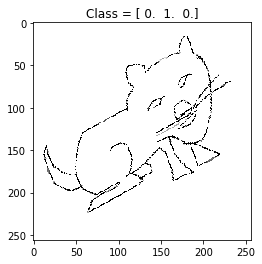

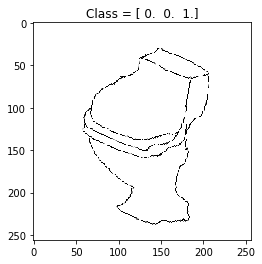

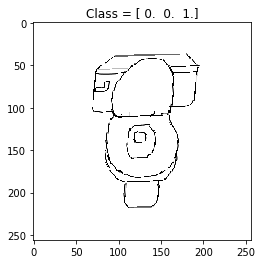

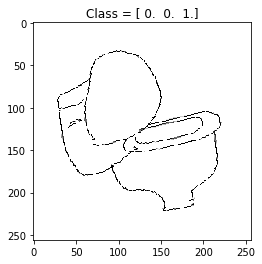

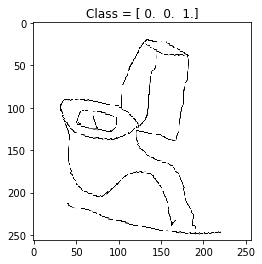

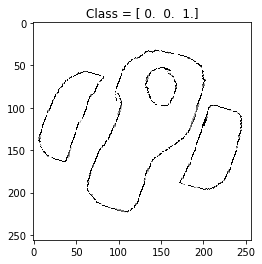

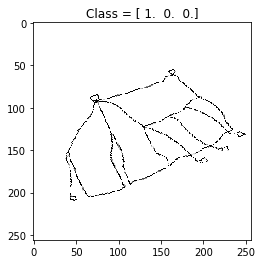

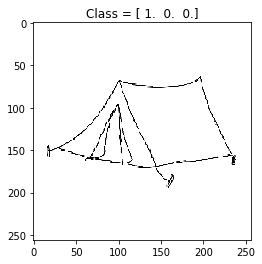

In [6]:
for X_batch, Y_batch in train_generator:
    print X_batch.shape, Y_batch.shape
#     plots(X_batch[:12,:,:,:], figsize=(12,12), rows=3)
    for i in range(len(Y_batch)):
        show_sample(X_batch[i, :, :, :], Y_batch[i])
        if i > 6:
            break
    break

In [9]:
model_name = 'sketchnet1'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

log_cb =\
    TensorBoard(log_dir='../logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
best_model_cb =\
    ModelCheckpoint('../models/'+model_name+'_best.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)
latest_model_cb =\
    ModelCheckpoint('../models/'+model_name+'_latest.h5', 
                    monitor='val_acc', verbose=0, 
                    save_weights_only=True, 
                    period=1)

In [10]:
# now try training a simple convnet
def build_sketchnet1():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), 
                            padding='same',
                            activation='relu',
                            input_shape=(img_width, img_height, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), 
                            padding='same', 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))

    model.add(Convolution2D(256, (3, 3), 
                            padding='same', 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # initialize optimizer
    opt = rmsprop(lr=0.0001)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model, opt

sketchnet1, opt1 = build_sketchnet1()

In [11]:
total_epochs=0

In [12]:
nb_epoch = 1
K.set_value(opt1.lr, 0.0001)

hist = sketchnet1.fit_generator(
        train_generator,
        steps_per_epoch = 18,
        epochs = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 1/1
18/18 [==============================] - 13s - loss: 2.1613 - acc: 0.3352 - val_loss: 1.0995 - val_acc: 0.3000


In [14]:
# set higher learning rate and train for more epochs:
K.set_value(opt1.lr, 0.001)

nb_epoch = 25

hist = sketchnet1.fit_generator(
        train_generator,
        steps_per_epoch = 18, # 180 train samples
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 6, # 60 test samples
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 2/25
18/18 [==============================] - 15s - loss: 1.6536 - acc: 0.3358 - val_loss: 1.0958 - val_acc: 0.3667
Epoch 3/25
18/18 [==============================] - 15s - loss: 1.1096 - acc: 0.3587 - val_loss: 1.0981 - val_acc: 0.3667
Epoch 4/25
18/18 [==============================] - 10s - loss: 1.1527 - acc: 0.3080 - val_loss: 1.1063 - val_acc: 0.3333
Epoch 5/25
18/18 [==============================] - 10s - loss: 1.4212 - acc: 0.3513 - val_loss: 1.0953 - val_acc: 0.3137
Epoch 6/25
18/18 [==============================] - 10s - loss: 1.1405 - acc: 0.4086 - val_loss: 1.1848 - val_acc: 0.3333
Epoch 7/25
18/18 [==============================] - 15s - loss: 1.0606 - acc: 0.4297 - val_loss: 0.8414 - val_acc: 0.6667
Epoch 8/25
18/18 [==============================] - 15s - loss: 1.0217 - acc: 0.6180 - val_loss: 0.8621 - val_acc: 0.7451
Epoch 9/25
18/18 [==============================] - 10s - loss: 0.7982 - acc: 0.7259 - val_loss: 1.1064 - val_acc: 0.4706
Epoch 10/25
18/18 [=====

In [15]:
K.set_value(opt1.lr, 0.0001)

nb_epoch = 10

hist = sketchnet1.fit_generator(
        train_generator,
        steps_per_epoch = 18, # 180 train samples
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 6, # 60 test samples
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[log_cb, 
                   best_model_cb,
                   latest_model_cb]
)
total_epochs += nb_epoch

Epoch 27/36
18/18 [==============================] - 10s - loss: 0.3056 - acc: 0.9055 - val_loss: 0.5468 - val_acc: 0.8235
Epoch 28/36
18/18 [==============================] - 10s - loss: 0.2327 - acc: 0.9105 - val_loss: 0.6161 - val_acc: 0.8333
Epoch 29/36
18/18 [==============================] - 10s - loss: 0.3279 - acc: 0.9055 - val_loss: 0.5999 - val_acc: 0.7833
Epoch 30/36
18/18 [==============================] - 10s - loss: 0.1929 - acc: 0.9389 - val_loss: 0.5845 - val_acc: 0.7451
Epoch 31/36
18/18 [==============================] - 10s - loss: 0.2418 - acc: 0.9216 - val_loss: 0.3236 - val_acc: 0.8824
Epoch 32/36
18/18 [==============================] - 10s - loss: 0.2812 - acc: 0.9049 - val_loss: 0.7001 - val_acc: 0.7500
Epoch 33/36
18/18 [==============================] - 10s - loss: 0.2495 - acc: 0.9000 - val_loss: 0.7467 - val_acc: 0.7451
Epoch 34/36
18/18 [==============================] - 10s - loss: 0.2360 - acc: 0.8994 - val_loss: 0.5645 - val_acc: 0.8039
Epoch 35/36
18/1

In [16]:
metrics = model.evaluate_generator(validation_generator, steps=6)
print model.metrics_names, metrics

['loss', 'acc'] [0.68547658125559485, 0.76666666070620215]


In [5]:
# now try with batchnorm:
# now try training a simple convnet
def build_model2():
    model = Sequential()
#     model.add(BatchNormalization(input_shape=(img_width, img_height, channels)))
    model.add(Convolution2D(64, (3, 3), 
                            padding='same',
                            input_shape=(img_width, img_height, channels)))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), 
                            padding='same'))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))

    model.add(Convolution2D(256, (3, 3), 
                            padding='same'))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
#     model.add(BatchNormalization())
    model.add(Activation('softmax'))

    # initialize optimizer
    opt = rmsprop(lr=0.0001)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model, opt

# tf.reset_default_graph()
model_bn, opt_bn = build_model2()

In [6]:
# set up logging
model_name = 'sketchnet1_bn'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

tensorboard_callback =\
    TensorBoard(log_dir='./logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
checkpoint_callback =\
    ModelCheckpoint('./models/'+model_name+'.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)

In [7]:
total_epochs = 0

In [8]:
nb_epoch = 1
K.set_value(opt_bn.lr, 0.0001)

hist = model_bn.fit_generator(
        train_generator,
        steps_per_epoch = 18,
        epochs = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

Epoch 1/1
18/18 [==============================] - 12s - loss: 1.1672 - acc: 0.5056 - val_loss: 1.3411 - val_acc: 0.3333


In [9]:
# set higher learning rate and train for more epochs:
K.set_value(opt_bn.lr, 0.001)

nb_epoch = 10

hist = model_bn.fit_generator(
        train_generator,
        steps_per_epoch = 18, # 180 train samples
        epochs = total_epochs+nb_epoch,
        validation_data = validation_generator,
        validation_steps = 6, # 60 test samples
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

Epoch 2/11
18/18 [==============================] - 6s - loss: 1.5679 - acc: 0.5833 - val_loss: 9.7626 - val_acc: 0.2833
Epoch 3/11
18/18 [==============================] - 10s - loss: 1.4299 - acc: 0.6611 - val_loss: 8.2115 - val_acc: 0.3333
Epoch 4/11
18/18 [==============================] - 6s - loss: 0.9634 - acc: 0.6889 - val_loss: 8.5027 - val_acc: 0.2667
Epoch 5/11
18/18 [==============================] - 10s - loss: 0.9064 - acc: 0.6889 - val_loss: 4.4665 - val_acc: 0.5000
Epoch 6/11
18/18 [==============================] - 6s - loss: 0.6550 - acc: 0.7833 - val_loss: 5.7421 - val_acc: 0.4333
Epoch 7/11
18/18 [==============================] - 6s - loss: 0.6856 - acc: 0.7611 - val_loss: 10.9686 - val_acc: 0.3167
Epoch 8/11
18/18 [==============================] - 10s - loss: 0.9345 - acc: 0.6833 - val_loss: 1.6266 - val_acc: 0.6333
Epoch 9/11
18/18 [==============================] - 6s - loss: 0.6059 - acc: 0.7889 - val_loss: 10.3500 - val_acc: 0.3333
Epoch 10/11
18/18 [========

In [10]:
metrics = model_bn.evaluate_generator(train_generator, steps=6)
print 'val', model_bn.metrics_names, metrics
metrics = model_bn.evaluate_generator(validation_generator, steps=6)
print 'val', model_bn.metrics_names, metrics

val ['loss', 'acc'] [2.8225011279185614, 0.61666668454806006]
val ['loss', 'acc'] [5.3783204158147173, 0.50000001986821496]


In [6]:
model_bn.load_weights('models/sketchnet1_bn.h5')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


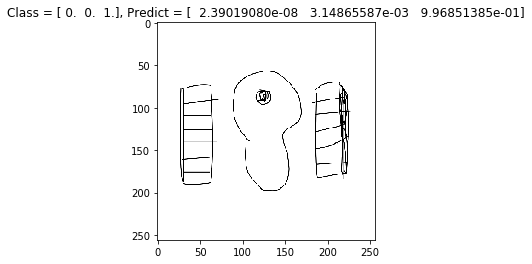

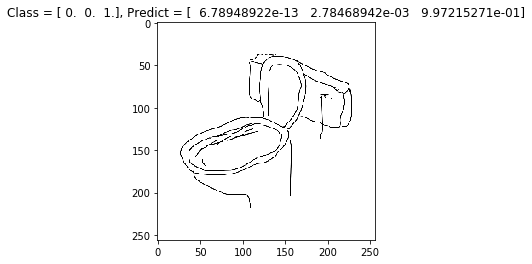

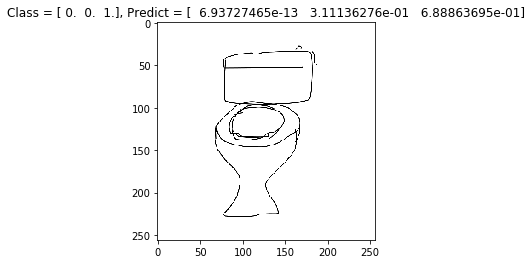

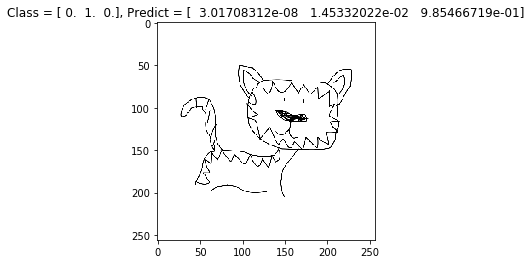

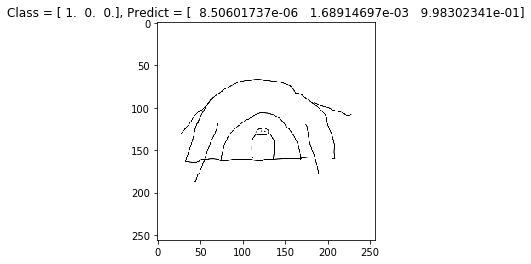

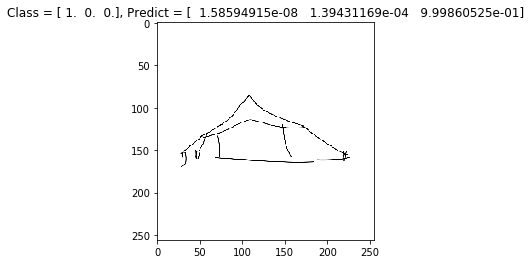

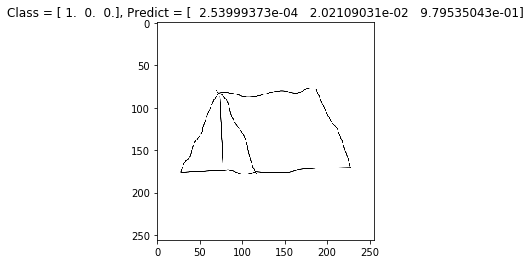

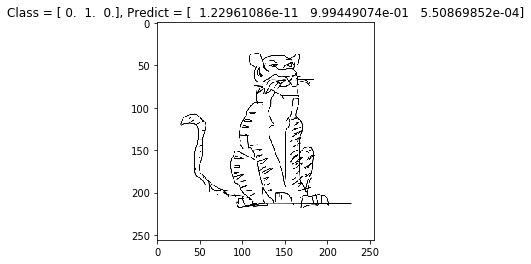

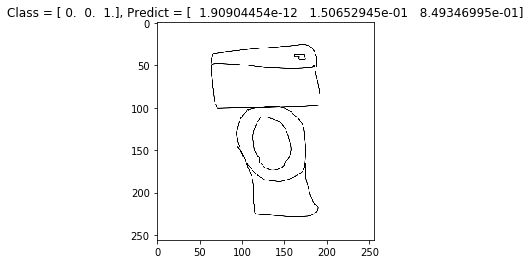

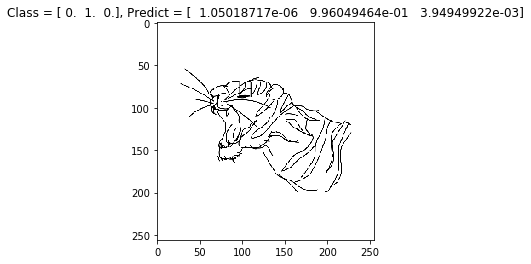

In [13]:
# load model and display some predictions
X_batch, y_batch = validation_generator.next()
y_pred = model_bn.predict(X_batch)
for i in range(y_batch.shape[0]):
    show_sample(X_batch[i], y_batch[i], y_pred[i])

In [ ]:
batch_size = 25

data_root = 'data/tu-berlin/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print num_classes, img_height, img_width, channels

In [ ]:
# ok batchnorm working now make larger model and train on full dataset
# now try with batchnorm:
# now try training a simple convnet
def build_sketchnet1():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), 
                            padding='same',
                            input_shape=(img_width, img_height, channels)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(128, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.0625))
    
    model.add(Convolution2D(256, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(256, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.125))
              
    model.add(Convolution2D(512, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(512, (3, 3), 
                            padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initialize optimizer
    opt = rmsprop(lr=0.0001)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model, opt

sketchnet1_full, opt_full = build_sketchnet1()
sketchnet1_full.summary()

In [6]:
# set up logging
model_name = 'sketchnet1_full'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

tensorboard_callback =\
    TensorBoard(log_dir='./logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
checkpoint_callback =\
    ModelCheckpoint('./models/'+model_name+'.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)

In [7]:
total_epochs = 0

In [8]:
nb_epoch = 1
K.set_value(opt_full.lr, 0.0001)

hist = sketchnet1_full.fit_generator(
        train_generator,
        steps_per_epoch = 530,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 270,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

Epoch 1/1
530/530 [==============================] - 852s - loss: 5.5222 - acc: 0.0034 - val_loss: 5.5215 - val_acc: 0.0040


In [ ]:
nb_epoch = 10
K.set_value(opt_full.lr, 0.01)

hist = sketchnet1_full.fit_generator(
        train_generator,
        steps_per_epoch = 530,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 270,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

Epoch 2/10
530/530 [==============================] - 826s - loss: 16.0293 - acc: 0.0032 - val_loss: 16.0560 - val_acc: 0.0039
Epoch 3/10
530/530 [==============================] - 826s - loss: 16.0573 - acc: 0.0038 - val_loss: 16.0584 - val_acc: 0.0037
Epoch 4/10
530/530 [==============================] - 827s - loss: 16.0536 - acc: 0.0040 - val_loss: 16.0512 - val_acc: 0.0041
Epoch 5/10
530/530 [==============================] - 826s - loss: 16.0536 - acc: 0.0040 - val_loss: 16.0512 - val_acc: 0.0041
Epoch 6/10
530/530 [==============================] - 826s - loss: 16.0488 - acc: 0.0043 - val_loss: 16.0536 - val_acc: 0.0040
Epoch 7/10
530/530 [==============================] - 827s - loss: 16.0573 - acc: 0.0038 - val_loss: 16.0417 - val_acc: 0.0047
Epoch 8/10
530/530 [==============================] - 826s - loss: 16.0463 - acc: 0.0045 - val_loss: 16.0584 - val_acc: 0.0037
Epoch 9/10
530/530 [==============================] - 826s - loss: 16.0585 - acc: 0.0037 - val_loss: 16.0512 - 

In [ ]:
nb_epoch = 50
K.set_value(opt_full.lr, 0.005)

hist = sketchnet1_full.fit_generator(
        train_generator,
        steps_per_epoch = 530,
        epochs = nb_epoch + total_epochs,
        validation_data = validation_generator,
        validation_steps = 270,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = total_epochs,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)
total_epochs += nb_epoch

In [ ]:
sketchnet